# Access logs no-uniforme

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from itertools import product
from pathlib import Path
from scipy.stats import expon
import pickle

## Auxiliar functions

In [3]:
###
class AccessLog:
    """ All operation in AccessLog (AL) """
    def __init__(self, df_users, df_rscs, df_env, df_op) -> None:
        """ Initialize AL attributes """
        self.df_users = df_users
        self.df_rscs = df_rscs
        self.df_env = df_env
        self.df_op = df_op
        self.user_attrs = df_users.columns
        self.rsrc_attrs = df_rscs.columns
        self.universal_access_log = []
    
    def compute_universal_al(self) -> None:
        """ Compute the universal Access Log (UAL). |UAL| = |U| x |R|"""
        access_log = []
        for user in self.df_users.values:
            for res in self.df_rscs.values:
                for env in self.df_env.values:   
                    for op in self.df_op.values:
                        access_log.append(list(user) + list(res)+ list(env) + list(op))
        
        access_log = pd.DataFrame(access_log)
        access_log.columns = list(self.df_users.columns) + list(self.df_rscs.columns) + list(self.df_env.columns) + list(self.df_op.columns)
        self.universal_access_log = access_log

    def tuple_rule_evaluation(self, item_rule, acc_req):
        if item_rule[0] == 0:
            if acc_req[item_rule[1]] != item_rule[2]:
                return False                
        if item_rule[0] == 1: # => attr1.val = attr2.val
            if acc_req[item_rule[1]] != acc_req[item_rule[2]]:
                return False
        if item_rule[0] == 2: # => attr in values.list
            if not acc_req[item_rule[1]] in item_rule[2]:
                return False
        if item_rule[0] == 3: # => attr < values.list
            if not acc_req[item_rule[1]] > item_rule[2]:
                return False
        if item_rule[0] == 4: # => attr != values.list
            if not acc_req[item_rule[1]] == item_rule[2]:
                return False
        return True

    def policy_evaluation(self, policy) -> None:
        """ Compare each access record with a policy set."""
        false_negs = [] # False negatives
        true_pos = [] # True positives
        len_policy = len(policy)
        counter = 0

        for acc_req in self.universal_access_log.iloc:
            denies_count = 0
            for rule in policy:
                res = True
                for item_rule in rule:
                    res = self.tuple_rule_evaluation(item_rule, acc_req)                    
                if res == False:
                    denies_count += 1
            if denies_count == len_policy:
                false_negs.append(acc_req)
            else:
                true_pos.append(acc_req)

            counter += 1
            if counter % 500000 == 0:
                print("Counter:", counter)
        
        false_negs = pd.DataFrame(false_negs)
        true_pos = pd.DataFrame(true_pos)

        print("FN;", len(false_negs), "\t\tTP:", len(true_pos))

        # Add "ACTION" column
        false_negs["ACTION"] = 0
        true_pos["ACTION"] = 1

        # Access log with "ACTION" column
        self.universal_access_log = pd.concat([true_pos,false_negs])

    def get_sparse_al(self, fraction, random_state=None, previous_al=None):        
        """ Compute the sparse access log (SAL) version. """
        acc_log = self.universal_access_log
        if isinstance(previous_al, pd.DataFrame):
            acc_log = previous_al
        sparse_positive_al = None   
        pos_access_req = acc_log[acc_log["ACTION"]==1]
        if random_state != None:
            sparse_positive_al = pos_access_req.sample(frac=fraction,
                                                       random_state=random_state)
        else:
            sparse_positive_al = pos_access_req.sample(frac=fraction)

        return pd.concat([sparse_positive_al, acc_log[acc_log["ACTION"]==0]])

    def get_noisy_al(self, fraction, random_state=None, previous_al=None):
        """ Compute the noisy access log (NAL) version. """
        acc_log = self.universal_access_log
        if isinstance(previous_al, pd.DataFrame):
            acc_log = previous_al

        noysi_al = None
        if random_state != None:
            noisy_separation = StratifiedShuffleSplit(n_splits = 1,
                                                      train_size = fraction,
                                                      random_state = random_state)
        else:
            noisy_separation = StratifiedShuffleSplit(n_splits = 1,
                                                      train_size = fraction)
        
        noisy_acc_log_selection = noisy_separation.split(acc_log, acc_log.ACTION)
                        
        noisy_acc_req = None
        normal_acc_req = None
        for noisy_idx, normal_idx, in noisy_acc_log_selection:
            noisy_acc_req = acc_log.iloc[noisy_idx]
            normal_acc_req = acc_log.iloc[normal_idx]

        # Change the resolution in the noisy_selection dataset
        noisy_acc_req["ACTION"] = np.where(noisy_acc_req["ACTION"] == 0, 1, 0)

        noysi_al = pd.concat([noisy_acc_req, normal_acc_req])

        return noysi_al

    def get_balanced_al(self, positive_frac, random_state = None, previous_al = None):
        acc_log = self.universal_access_log
        
        if isinstance(previous_al, pd.DataFrame):
            acc_log = previous_al        

        # Compute the original balanced
        pos_acc_log = acc_log[acc_log["ACTION"]==1]
        neg_acc_log = acc_log[acc_log["ACTION"]==0]

        len_al = len(acc_log)
        len_pos_ar = len(pos_acc_log)

        limit_positive_frac = ( len_pos_ar * 100 ) / len_al

        if positive_frac < limit_positive_frac and positive_frac > 1:
            print("Is not possible")
            return
        
        len_neg_ar = int(( (1-positive_frac) * 100 * len_pos_ar ) / (positive_frac*100))        

        neg_acc_req = []
        if random_state != None:
            neg_acc_req = neg_acc_log.sample(n=len_neg_ar,
                                             random_state=random_state)
        else:
            neg_acc_req = neg_acc_log.sample(n=len_neg_ar)

        return pd.concat([pos_acc_log, neg_acc_req])


In [4]:
### Get probability distribution

def get_probability_distribution(n, sample_size, probability_parameters, type="normal",):
    """ Get the probability distribution for n elementsin sample size."""
    distri = None

    if type==None:
        return None

    if type=="normal":
        distri = np.random.normal(probability_parameters["mu"], 
                                  probability_parameters["sigma"], 
                                  size=sample_size)        

    if type=="pareto":        
        distri = (np.random.pareto(probability_parameters["alpha"], sample_size) + 1) * probability_parameters["mu"]        

    if type=="poisson":
        distri = np.random.poisson(probability_parameters["lam"],
                                   size=sample_size)        

    if type=="exponential":
        new_scale = 1 / probability_parameters["lam"]
        # Generate values for the x-axis
        x = np.linspace(0, n, sample_size)
        # Calculate the PDF with the new scale parameter
        distri = expon.pdf(x, scale=new_scale)

    count, _, _ = plt.hist(distri, n)  
    return count/sample_size

def get_sample_by_distribution(access_log, sample_size, prob_distri, class_name):
    """ Sampling a dataframe based on a given distribution. """
    new_sample = pd.DataFrame() # Store all access requests
    for i in prob_distri.iloc:
        temp = access_log[access_log[class_name]==i[0]]
        n_samples = int(i[1]*sample_size)        
        temp = temp.sample(n=n_samples, replace=True)
        new_sample = pd.concat([new_sample, temp])

    return new_sample

## Main

In [4]:
### Load an access log
file_path = "../data/HC-universal.csv"
#file_path = "../../SecondYear/01-Datasets/IOT-AL-universal.csv"
acc_log = pd.read_csv(file_path)
acc_log = acc_log[acc_log.columns[1:]]

print("### *** Access Log loaded *** ###")
print(acc_log.info())

### *** Access Log loaded *** ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153760 entries, 0 to 153759
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uname        153760 non-null  object
 1   position     153760 non-null  object
 2   uward        153760 non-null  object
 3   specialties  153760 non-null  object
 4   teams        153760 non-null  object
 5   agentfor     153760 non-null  object
 6   type         153760 non-null  object
 7   author       153760 non-null  object
 8   patient      153760 non-null  object
 9   topics       153760 non-null  object
 10  tratingTeam  153760 non-null  object
 11  rward        153760 non-null  object
 12  rname        153760 non-null  int64 
 13  ACTION       153760 non-null  int64 
dtypes: int64(2), object(12)
memory usage: 16.4+ MB
None


## Users distribution

In [7]:
### Get all users
users = acc_log.uname.unique()
print("# users:", len(users), "\t Head ->", users[:5], "\t tail -> ", users[-5:])

# users: 120 	 Head -> [0 1 2 3 4] 	 tail ->  [118 119 120 121 122]


### Normal

In [8]:
proba_param = {"lam": 5}
prob = get_probability_distribution(len(users), len(acc_log), proba_param, "normal")
df_user_prob = pd.DataFrame({"UID": users, "prob": prob})
print("Done!")

KeyError: 'mu'

In [11]:
### Get sample distribution
normal_acc_log = get_sample_by_distribution(acc_log, len(acc_log), df_user_prob, "uname")
print("*** Done! ***")
print(normal_acc_log.info())

*** Done! ***
<class 'pandas.core.frame.DataFrame'>
Int64Index: 153756 entries, 26307 to 24395
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uname        153756 non-null  object
 1   position     153756 non-null  object
 2   uward        153756 non-null  object
 3   specialties  153756 non-null  object
 4   teams        153756 non-null  object
 5   agentfor     153756 non-null  object
 6   type         153756 non-null  object
 7   author       153756 non-null  object
 8   patient      153756 non-null  object
 9   topics       153756 non-null  object
 10  tratingTeam  153756 non-null  object
 11  rward        153756 non-null  object
 12  rname        153756 non-null  int64 
 13  ACTION       153756 non-null  int64 
dtypes: int64(2), object(12)
memory usage: 17.6+ MB
None


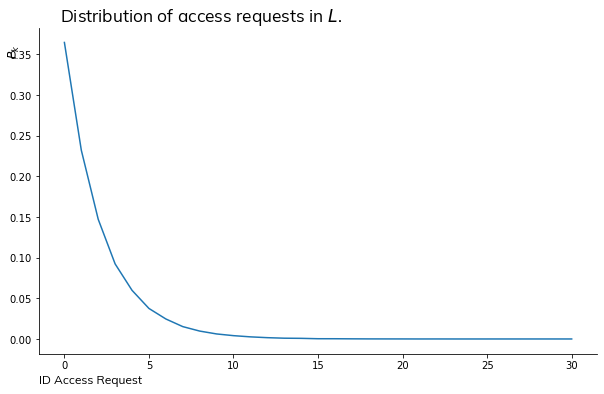

In [68]:
### Selection only user-resource access requests

fpath = Path(mpl.get_data_path(), "C:\\Users\\danie\\AppData\\Local\\Microsoft\\Windows\\Fonts\\mulish-regular.ttf")


fig, ax = plt.subplots(figsize=(10, 6))
ax.spines[['right', 'top']].set_visible(False)
to_plot = df_user_prob["prob"]
ax.plot(range(len(to_plot)), to_plot)
ax.set_xlabel('ID Access Request', loc="left", size="large", font=fpath)
ax.set_ylabel('$P_k$', loc="top", size="large", font=fpath, parse_math=True)
ax.yaxis.set_label_coords(-0.03,0.95)
ax.set_title("Distribution of access requests in $L$.", size="xx-large",  font=fpath, x=0.29, y=1, parse_math=True)
plt.show()

Done!


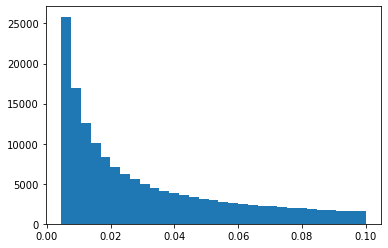

In [131]:
proba_param = {"lam": 0.1}
prob = get_probability_distribution(len(users), len(acc_log), proba_param, "exponential")
df_user_prob = pd.DataFrame({"UID": users, "prob": prob})
# Plot the PDF
print("Done!")

In [132]:
### Get sample distribution
normal_acc_log = get_sample_by_distribution(acc_log, len(acc_log), df_user_prob, "uname")
print("*** Done! ***")
print(normal_acc_log.info())

*** Done! ***
<class 'pandas.core.frame.DataFrame'>
Int64Index: 153757 entries, 25211 to 152331
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uname        153757 non-null  object
 1   position     153757 non-null  object
 2   uward        153757 non-null  object
 3   specialties  153757 non-null  object
 4   teams        153757 non-null  object
 5   agentfor     153757 non-null  object
 6   type         153757 non-null  object
 7   author       153757 non-null  object
 8   patient      153757 non-null  object
 9   topics       153757 non-null  object
 10  tratingTeam  153757 non-null  object
 11  rward        153757 non-null  object
 12  rname        153757 non-null  int64 
 13  ACTION       153757 non-null  int64 
dtypes: int64(2), object(12)
memory usage: 17.6+ MB
None


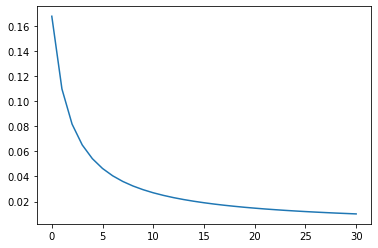

In [133]:
a = normal_acc_log.uname.value_counts() / len(normal_acc_log)
plt.plot(range(31), a)

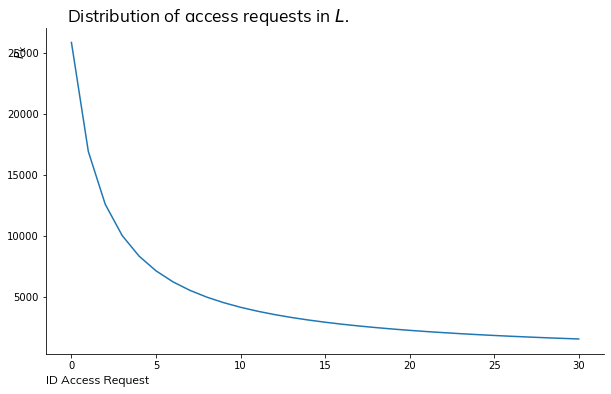

In [114]:
### Selection only user-resource access requests

fpath = Path(mpl.get_data_path(), "C:\\Users\\danie\\AppData\\Local\\Microsoft\\Windows\\Fonts\\mulish-regular.ttf")


fig, ax = plt.subplots(figsize=(10, 6))
ax.spines[['right', 'top']].set_visible(False)
to_plot = prob
ax.plot(range(len(to_plot)), to_plot)
ax.set_xlabel('ID Access Request', loc="left", size="large", font=fpath)
ax.set_ylabel('$P_k$', loc="top", size="large", font=fpath, parse_math=True)
ax.yaxis.set_label_coords(-0.03,0.95)
ax.set_title("Distribution of access requests in $L$.", size="xx-large",  font=fpath, x=0.29, y=1, parse_math=True)
plt.show()

In [ ]:
### Get sample distribution
normal_acc_log = get_sample_by_distribution(acc_log, len(acc_log), df_user_prob, "uname")
print("*** Done! ***")
print(normal_acc_log.info())

Done!


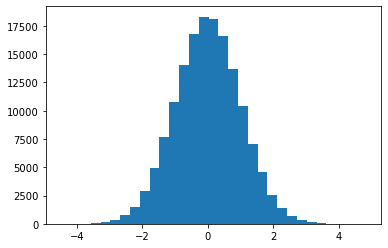

In [7]:
proba_param = {"mu": 0, "sigma": 1}
prob = get_probability_distribution(len(users), len(acc_log), proba_param, "normal")
df_user_prob = pd.DataFrame({"UID": users, "prob": prob})
print("Done!")

Sum p(x) = 1.0


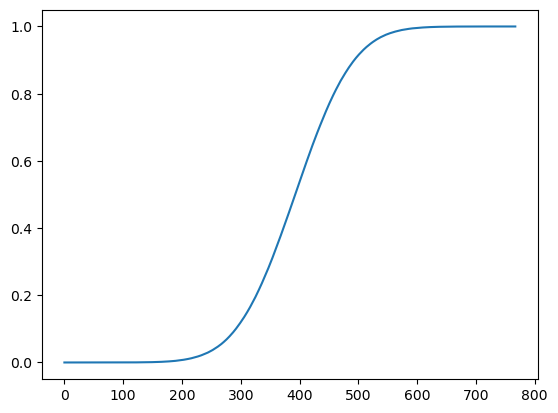

In [7]:
### Check CDF
print("Sum p(x) =", df_user_prob.prob.sum())
cdf = np.cumsum(df_user_prob.prob)
plt.plot(range(len(cdf)), cdf)

In [8]:
### Get sample distribution
normal_acc_log = get_sample_by_distribution(acc_log, len(acc_log), df_user_prob, "uname")
print("*** Done! ***")
print(normal_acc_log.info())

*** Done! ***
<class 'pandas.core.frame.DataFrame'>
Index: 686374 entries, 442 to 685836
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   position     645612 non-null  object
 1   uward        481069 non-null  object
 2   specialties  571885 non-null  object
 3   teams        588478 non-null  object
 4   agentfor     490752 non-null  object
 5   uname        686374 non-null  int64 
 6   type         686374 non-null  object
 7   author       686374 non-null  object
 8   patient      686374 non-null  object
 9   topics       686374 non-null  object
 10  tratingTeam  686374 non-null  object
 11  rward        686374 non-null  object
 12  rname        686374 non-null  int64 
dtypes: int64(2), object(11)
memory usage: 73.3+ MB
None


In [12]:
print("|L-original| únicos: ", len(acc_log.drop_duplicates()))
print("|L-normal| únicos: ", len(normal_acc_log.drop_duplicates()))
print("Diferencia = ", len(acc_log.drop_duplicates()) - len(normal_acc_log.drop_duplicates()))

|L-original| únicos:  686400
|L-normal| únicos:  225986
Diferencia =  460414


In [9]:
### new data information
print("Size of Original Access Log = ", len(acc_log))
print("Size of normal Access Log = ", len(normal_acc_log),"\n")

new_prob_distri = normal_acc_log.uname.value_counts(normalize=True)
print("# users in Original Access Log =", len(users))
print("# users in normal Access Log =", len(new_prob_distri))
print("Difference =", len(users) - len(new_prob_distri))

Size of Original Access Log =  686400
Size of normal Access Log =  686374 

# users in Original Access Log = 768
# users in normal Access Log = 660
Difference = 108


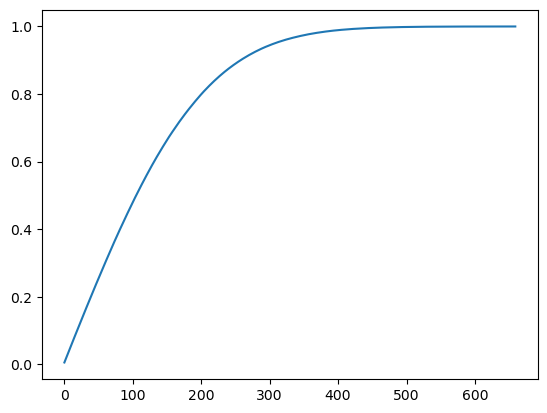

In [13]:
cdf = np.cumsum(sorted(new_prob_distri, reverse=True))
plt.plot(range(len(cdf)), cdf)

### Pareto

Done!


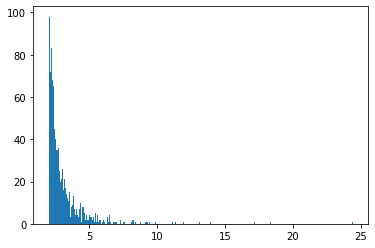

In [27]:
proba_param = {"alpha": 3., "mu": 2.}
prob = get_probability_distribution(len(users), len(acc_log), proba_param, "pareto")
df_user_prob = pd.DataFrame({"UID": users, "prob": prob})
print("Done!")

Sum p(x) = 0.9999999999999999


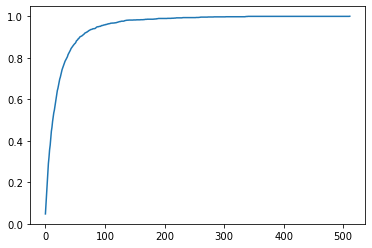

In [18]:
### Check CDF
print("Sum p(x) =", df_user_prob.prob.sum())
cdf = np.cumsum(df_user_prob.prob)
plt.plot(range(len(cdf)), cdf)

In [6]:
with open("test", "rb") as fp:   # Unpickling
    b = pickle.load(fp)
print("Done len:", len(b))

Done len: 512


In [8]:
df_user_prob = pd.DataFrame({"UID": users, "prob": b})
df_user_prob

,UID,prob
0,0,0.000039
1,1,0.000041
2,2,0.000044
3,3,0.000046
4,4,0.000048
...,...,...
507,507,0.001135
508,508,0.001137
509,509,0.001139
510,510,0.001141


In [9]:
### Get sample distribution
pareto_acc_log = get_sample_by_distribution(acc_log, len(acc_log), df_user_prob, "uname")
print("*** Done! ***")
print(pareto_acc_log.info())

*** Done! ***
<class 'pandas.core.frame.DataFrame'>
Int64Index: 254 entries, 917 to 1678
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   adminroles   0 non-null      object
 1   projects     254 non-null    object
 2   departmentu  0 non-null      object
 3   projectsled  0 non-null      object
 4   expertiseu   254 non-null    object
 5   isemployee   254 non-null    object
 6   task         254 non-null    object
 7   uname        254 non-null    int64 
 8   rname        254 non-null    object
 9   type         254 non-null    object
 10  project      254 non-null    object
 11  department   254 non-null    object
 12  expertise    254 non-null    object
 13  proprietary  254 non-null    object
dtypes: int64(1), object(13)
memory usage: 29.8+ KB
None


In [10]:
print("|L-original| únicos: ", len(acc_log.drop_duplicates()))
print("|L-normal| únicos: ", len(pareto_acc_log.drop_duplicates()))
print("Diferencia = ", len(acc_log.drop_duplicates()) - len(pareto_acc_log.drop_duplicates()))

|L-original| únicos:  1680
|L-normal| únicos:  254
Diferencia =  1426


In [11]:
### new data information
print("Size of Original Access Log = ", len(acc_log))
print("Size of Pareto Access Log = ", len(pareto_acc_log),"\n")

new_prob_distri = pareto_acc_log.uname.value_counts(normalize=True)
print("# users in Original Access Log =", len(users))
print("# users in Pareto Access Log =", len(new_prob_distri))
print("Difference =", len(users) - len(new_prob_distri))

Size of Original Access Log =  1680
Size of Pareto Access Log =  254 

# users in Original Access Log = 512
# users in Pareto Access Log = 254
Difference = 258


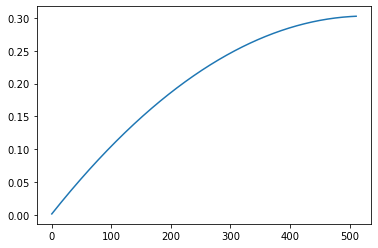

In [12]:
cdf = np.cumsum(sorted(b, reverse=True))
plt.plot(range(len(cdf)), cdf)

## Resources

In [13]:
### Get all users
res = acc_log.rname.unique()
print("# resources:", len(res), "\t Head ->", res[:5], "\t tail -> ", res[-5:])

# resources: 40 	 Head -> ['proj11budget' 'proj11task1a' 'proj11task2a' 'proj11task1' 'proj11task2'] 	 tail ->  ['proj22task2prop' 'proj11sched' 'proj12sched' 'proj21sched' 'proj22sched']


### normal

Done!


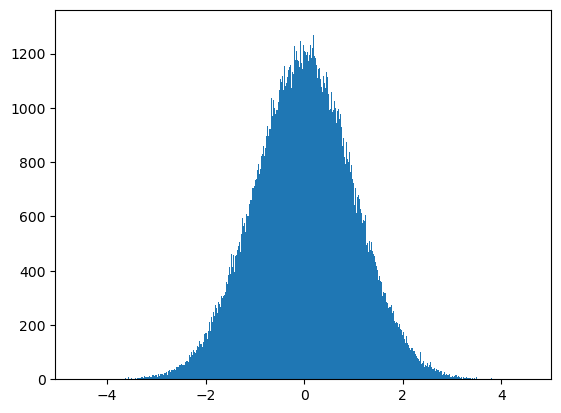

In [40]:
proba_param = {"mu": 0, "sigma": 1}
prob = get_probability_distribution(len(res), len(acc_log), proba_param, "normal")
df_res_prob = pd.DataFrame({"RID": res, "prob": prob})
print("Done!")

Sum p(x) = 1.0


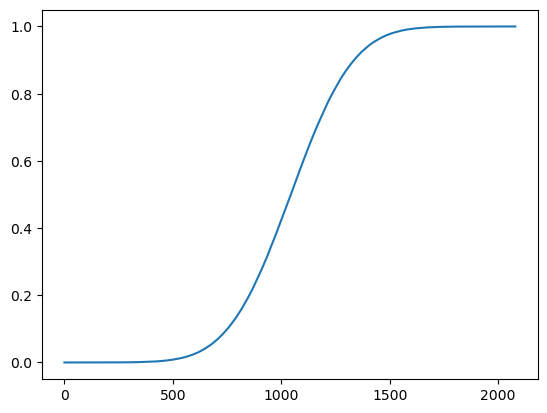

In [41]:
### Check CDF
print("Sum p(x) =", df_res_prob.prob.sum())
cdf = np.cumsum(df_res_prob.prob)
plt.plot(range(len(cdf)), cdf)

In [42]:
### Get sample distribution
normal_acc_log = get_sample_by_distribution(acc_log, len(acc_log), df_res_prob, "rname")
print("*** Done! ***")
print(normal_acc_log.info())

*** Done! ***
<class 'pandas.core.frame.DataFrame'>
Index: 686383 entries, 78910 to 204984
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   position     494385 non-null  object
 1   uward        494578 non-null  object
 2   specialties  572298 non-null  object
 3   teams        593717 non-null  object
 4   agentfor     535093 non-null  object
 5   uname        686383 non-null  int64 
 6   type         686383 non-null  object
 7   author       686383 non-null  object
 8   patient      686383 non-null  object
 9   topics       686383 non-null  object
 10  tratingTeam  686383 non-null  object
 11  rward        686383 non-null  object
 12  rname        686383 non-null  int64 
dtypes: int64(2), object(11)
memory usage: 73.3+ MB
None


In [43]:
print("|L-original| únicos: ", len(acc_log.drop_duplicates()))
print("|L-normal| únicos: ", len(normal_acc_log.drop_duplicates()))
print("Diferencia = ", len(acc_log.drop_duplicates()) - len(normal_acc_log.drop_duplicates()))

|L-original| únicos:  686400
|L-normal| únicos:  292931
Diferencia =  393469


In [44]:
### new data information
print("Size of Original Access Log = ", len(acc_log))
print("Size of normal Access Log = ", len(normal_acc_log),"\n")

new_prob_distri = normal_acc_log.rname.value_counts(normalize=True)
print("# users in Original Access Log =", len(res))
print("# users in normal Access Log =", len(new_prob_distri))
print("Difference =", len(res) - len(new_prob_distri))

Size of Original Access Log =  686400
Size of normal Access Log =  686383 

# users in Original Access Log = 2080
# users in normal Access Log = 1785
Difference = 295


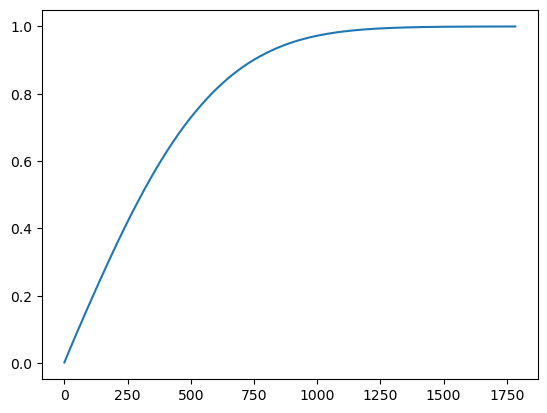

In [47]:
cdf = np.cumsum(sorted(new_prob_distri, reverse=True))
plt.plot(range(len(cdf)),cdf)

### Pareto

In [ ]:
proba_param = {"alpha": 3., "mu": 2.}
prob = get_probability_distribution(len(res), len(acc_log), proba_param, "pareto")
df_res_prob = pd.DataFrame({"RID": res, "prob": prob})
print("Done!")

In [ ]:
### Check CDF
print("Sum p(x) =", df_res_prob.prob.sum())
cdf = np.cumsum(df_res_prob.prob)
plt.scatter(range(len(cdf)),cdf, marker="*")

In [ ]:
### Get sample distribution
pareto_acc_log = get_sample_by_distribution(acc_log, len(acc_log), df_res_prob, "rname")
print("*** Done! ***")
print(pareto_acc_log.info())

In [ ]:
### new data information
print("Size of Original Access Log = ", len(acc_log))
print("Size of normal Access Log = ", len(pareto_acc_log),"\n")

new_prob_distri = pareto_acc_log.rname.value_counts(normalize=True)
print("# users in Original Access Log =", len(users))
print("# users in normal Access Log =", len(new_prob_distri))
print("Difference =", len(users) - len(new_prob_distri))

In [ ]:
cdf = np.cumsum(sorted(new_prob_distri, reverse=True))
plt.scatter(range(len(cdf)),cdf, marker="*")

## Combine

In [59]:
### Get all resources
res = acc_log.rname.unique()
print("# resources:", len(res), "\t Head ->", res[:5], "\t tail -> ", res[-5:])

### Get all users
users = acc_log.uname.unique()
print("# users:", len(users), "\t Head ->", users[:5], "\t tail -> ", users[-5:])

# resources: 4960 	 Head -> [0 1 2 3 4] 	 tail ->  [2467 2468 2469 2470 2471]
# users: 31 	 Head -> ['oncNurse1' 'carNurse1' 'doc1' 'doc2' 'doc3'] 	 tail ->  ['doc25' 'oncPat1' 'carPat1' 'oncAgent1' 'carAgent1']


### Normal

Done!


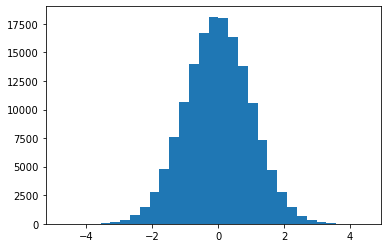

In [60]:
proba_param = {"mu": 0, "sigma": 1}
prob = get_probability_distribution(len(users), len(acc_log), proba_param, "normal")
df_user_prob = pd.DataFrame({"UID": users, "prob": prob})
print("Done!")

In [61]:
### Get sample distribution
normal_acc_log = get_sample_by_distribution(normal_acc_log, len(normal_acc_log), df_user_prob, "uname")
print("*** Done! ***")

*** Done! ***


Done!


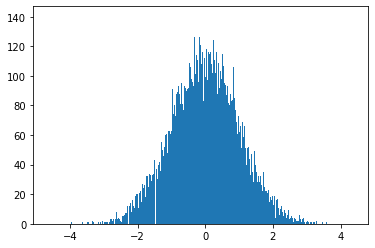

In [62]:
proba_param = {"mu": 0, "sigma": 1}
prob = get_probability_distribution(len(res), len(acc_log), proba_param, "normal")
df_res_prob = pd.DataFrame({"RID": res, "prob": prob})
print("Done!")

In [63]:
### Get sample distribution
normal_acc_log = get_sample_by_distribution(acc_log, len(acc_log), df_res_prob, "rname")
print("*** Done! ***")

*** Done! ***


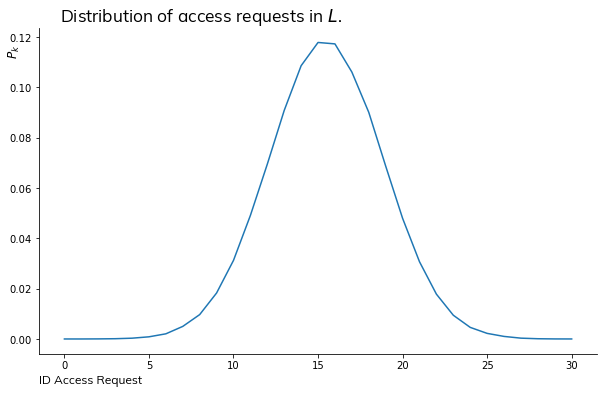

In [64]:
### Selection only user-resource access requests

fpath = Path(mpl.get_data_path(), "C:\\Users\\danie\\AppData\\Local\\Microsoft\\Windows\\Fonts\\mulish-regular.ttf")


fig, ax = plt.subplots(figsize=(10, 6))
ax.spines[['right', 'top']].set_visible(False)
to_plot = df_user_prob["prob"]
ax.plot(range(len(to_plot)), to_plot)
ax.set_xlabel('ID Access Request', loc="left", size="large", font=fpath)
ax.set_ylabel('$P_k$', loc="top", size="large", font=fpath, parse_math=True)
ax.yaxis.set_label_coords(-0.03,0.95)
ax.set_title("Distribution of access requests in $L$.", size="xx-large",  font=fpath, x=0.29, y=1, parse_math=True)
plt.show()

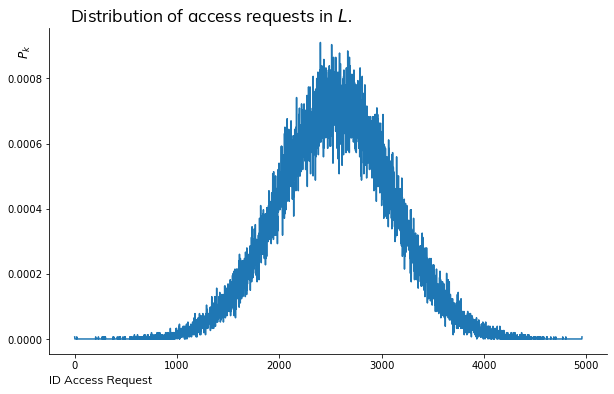

In [65]:
### Selection only user-resource access requests

fpath = Path(mpl.get_data_path(), "C:\\Users\\danie\\AppData\\Local\\Microsoft\\Windows\\Fonts\\mulish-regular.ttf")


fig, ax = plt.subplots(figsize=(10, 6))
ax.spines[['right', 'top']].set_visible(False)
to_plot = df_res_prob["prob"]
ax.plot(range(len(to_plot)), to_plot)
ax.set_xlabel('ID Access Request', loc="left", size="large", font=fpath)
ax.set_ylabel('$P_k$', loc="top", size="large", font=fpath, parse_math=True)
ax.yaxis.set_label_coords(-0.03,0.95)
ax.set_title("Distribution of access requests in $L$.", size="xx-large",  font=fpath, x=0.29, y=1, parse_math=True)
plt.show()

In [66]:
### Write the access log

normal_acc_log.to_csv("HC-Normal-universal.csv")

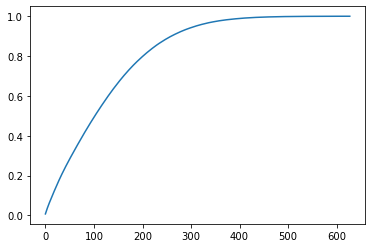

In [143]:
### Users
new_prob_distri = normal_acc_log.uname.value_counts(normalize=True)
cdf = np.cumsum(sorted(new_prob_distri, reverse=True))
plt.plot(range(len(cdf)), cdf)

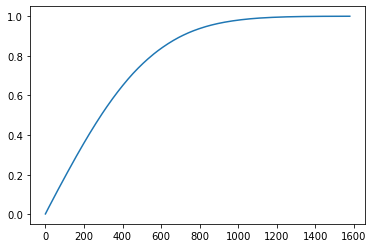

In [142]:
### Resources
new_prob_distri = normal_acc_log.rname.value_counts(normalize=True)
cdf = np.cumsum(sorted(new_prob_distri, reverse=True))
plt.plot(range(len(cdf)), cdf)

### Pareto

Done!


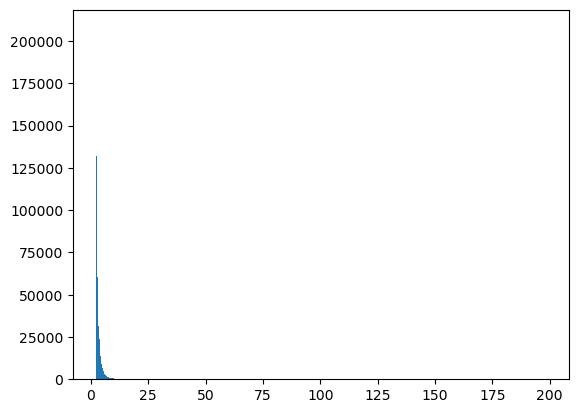

In [60]:
proba_param = {"alpha": 3., "mu": 2.}
prob = get_probability_distribution(len(users), len(acc_log), proba_param, "pareto")
df_user_prob = pd.DataFrame({"UID": users, "prob": prob})
print("Done!")

Sum p(x) = 1.0


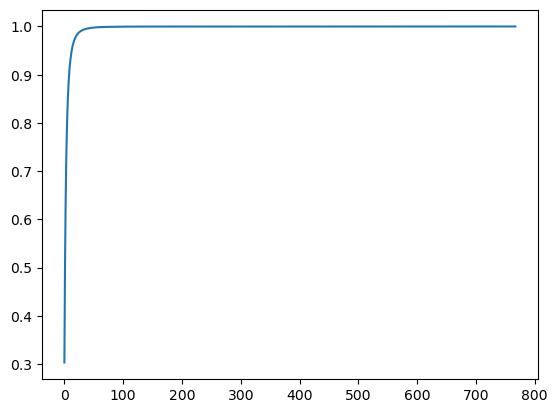

In [61]:
### Check CDF
print("Sum p(x) =", df_user_prob.prob.sum())
cdf = np.cumsum(df_user_prob.prob)
plt.plot(range(len(cdf)), cdf)

In [23]:
with open("users-distri", "rb") as fp:   # Unpickling
    b = pickle.load(fp)
print("Done len:", len(b))

Done len: 101


In [24]:
df_user_prob = pd.DataFrame({"UID": users, "prob": b})
df_user_prob.head()

,UID,prob
0,applicant1,0.003155
1,csStu1,0.003155
2,csStu2,0.003155
3,csStu3,0.003155
4,csStu4,0.003155


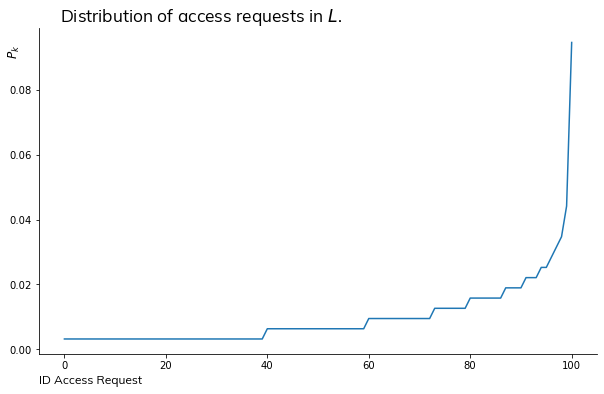

In [25]:
### Selection only user-resource access requests

fpath = Path(mpl.get_data_path(), "C:\\Users\\danie\\AppData\\Local\\Microsoft\\Windows\\Fonts\\mulish-regular.ttf")


fig, ax = plt.subplots(figsize=(10, 6))
ax.spines[['right', 'top']].set_visible(False)
to_plot = df_user_prob["prob"]
ax.plot(range(len(to_plot)), to_plot)
ax.set_xlabel('ID Access Request', loc="left", size="large", font=fpath)
ax.set_ylabel('$P_k$', loc="top", size="large", font=fpath, parse_math=True)
ax.yaxis.set_label_coords(-0.03,0.95)
ax.set_title("Distribution of access requests in $L$.", size="xx-large",  font=fpath, x=0.29, y=1, parse_math=True)
plt.show()

In [26]:
### Get sample distribution
pareto_acc_log = get_sample_by_distribution(acc_log, len(acc_log), df_user_prob, "uname")
print("*** Done! ***")
print(pareto_acc_log.info())

*** Done! ***
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27937 entries, 1199 to 976
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   uname        27937 non-null  object
 1   position     27937 non-null  object
 2   departmentu  27937 non-null  object
 3   crsTaken     27937 non-null  object
 4   crsTaught    27937 non-null  object
 5   isChair      27937 non-null  int64 
 6   rName        27937 non-null  object
 7   type         27937 non-null  object
 8   student      27937 non-null  object
 9   rDepartment  27937 non-null  object
 10  csr          27937 non-null  object
 11  ACTION       27937 non-null  int64 
dtypes: int64(2), object(10)
memory usage: 2.8+ MB
None


In [27]:
with open("resrs-distri", "rb") as fp:   # Unpickling
    b = pickle.load(fp)
print("Done len:", len(b))

Done len: 24


In [28]:
df_res_prob = pd.DataFrame({"UID": res, "prob": b})
df_res_prob.head()

,UID,prob
0,application1,0.001357
1,cs101gradebook,0.001357
2,csStu1application,0.001357
3,csStu1trans,0.001357
4,cs601gradebook,0.001357


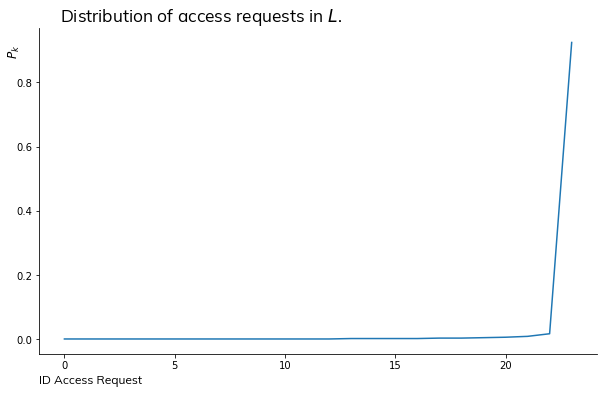

In [29]:
### Selection only user-resource access requests

fpath = Path(mpl.get_data_path(), "C:\\Users\\danie\\AppData\\Local\\Microsoft\\Windows\\Fonts\\mulish-regular.ttf")


fig, ax = plt.subplots(figsize=(10, 6))
ax.spines[['right', 'top']].set_visible(False)
to_plot = df_res_prob["prob"]
ax.plot(range(len(to_plot)), to_plot)
ax.set_xlabel('ID Access Request', loc="left", size="large", font=fpath)
ax.set_ylabel('$P_k$', loc="top", size="large", font=fpath, parse_math=True)
ax.yaxis.set_label_coords(-0.03,0.95)
ax.set_title("Distribution of access requests in $L$.", size="xx-large",  font=fpath, x=0.29, y=1, parse_math=True)
plt.show()

In [31]:
### Get sample distribution
pareto_acc_log2 = get_sample_by_distribution(pareto_acc_log, len(pareto_acc_log), df_res_prob, "rName")
print("*** Done! ***")
print(pareto_acc_log2.info())

*** Done! ***
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27918 entries, 11610 to 19173
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   uname        27918 non-null  object
 1   position     27918 non-null  object
 2   departmentu  27918 non-null  object
 3   crsTaken     27918 non-null  object
 4   crsTaught    27918 non-null  object
 5   isChair      27918 non-null  int64 
 6   rName        27918 non-null  object
 7   type         27918 non-null  object
 8   student      27918 non-null  object
 9   rDepartment  27918 non-null  object
 10  csr          27918 non-null  object
 11  ACTION       27918 non-null  int64 
dtypes: int64(2), object(10)
memory usage: 2.8+ MB
None


Done!


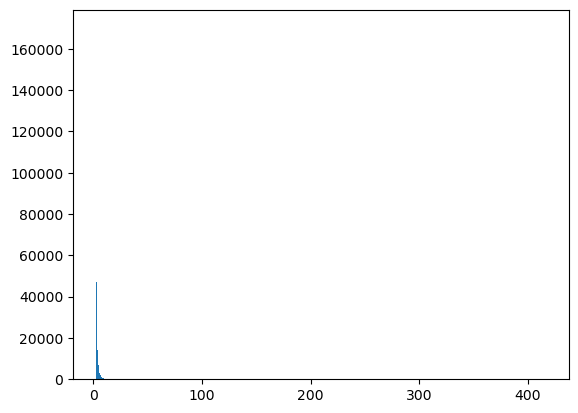

In [ ]:
proba_param = {"alpha": 3., "mu": 2.}
prob = get_probability_distribution(len(res), len(pareto_acc_log), proba_param, "pareto")
df_res_prob = pd.DataFrame({"RID": res, "prob": prob})
print("Done!")

Sum p(x) = 1.0


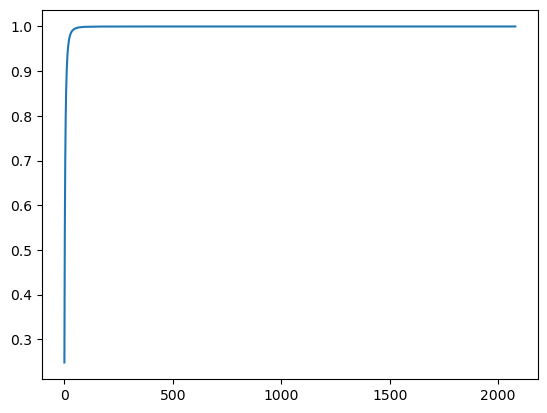

In [ ]:
### Check CDF
print("Sum p(x) =", df_res_prob.prob.sum())
cdf = np.cumsum(df_res_prob.prob)
plt.plot(range(len(cdf)),cdf)

In [ ]:
### Get sample distribution
pareto_acc_log = get_sample_by_distribution(pareto_acc_log, len(pareto_acc_log), df_res_prob, "rname")
print("*** Done! ***")
print(pareto_acc_log.info())

*** Done! ***
<class 'pandas.core.frame.DataFrame'>
Index: 686397 entries, 3640 to 40079
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   position     686397 non-null  object
 1   uward        686395 non-null  object
 2   specialties  27531 non-null   object
 3   teams        220624 non-null  object
 4   agentfor     332599 non-null  object
 5   uname        686397 non-null  int64 
 6   type         686397 non-null  object
 7   author       686397 non-null  object
 8   patient      686397 non-null  object
 9   topics       686397 non-null  object
 10  tratingTeam  686397 non-null  object
 11  rward        686397 non-null  object
 12  rname        686397 non-null  int64 
dtypes: int64(2), object(11)
memory usage: 73.3+ MB
None


In [32]:
print("|L-original| únicos: ", len(acc_log.drop_duplicates()))
print("|L-normal| únicos: ", len(pareto_acc_log.drop_duplicates()))
print("Diferencia = ", len(acc_log.drop_duplicates()) - len(pareto_acc_log.drop_duplicates()))

|L-original| únicos:  27977
|L-normal| únicos:  14319
Diferencia =  13658


In [33]:
### new data information
print("Size of Original Access Log = ", len(acc_log))
print("Size of normal Access Log = ", len(pareto_acc_log2),"\n")

new_prob_distri = pareto_acc_log2.uname.value_counts(normalize=True)
print("# users in Original Access Log =", len(users))
print("# users in normal Access Log =", len(new_prob_distri))
print("Difference =", len(users) - len(new_prob_distri))

Size of Original Access Log =  27977
Size of normal Access Log =  27918 

# users in Original Access Log = 101
# users in normal Access Log = 101
Difference = 0


In [35]:
new_prob_distri = pareto_acc_log2.rName.value_counts(normalize=True)
print("# users in Original Access Log =", len(res))
print("# users in normal Access Log =", len(new_prob_distri))
print("Difference =", len(res) - len(new_prob_distri))

# users in Original Access Log = 24
# users in normal Access Log = 24
Difference = 0


In [36]:
### Write the access log

pareto_acc_log2.to_csv("UN-Pareto-AMZ-universal.csv")

In [42]:
print(len(pareto_acc_log2))
print(len(pareto_acc_log2.drop_duplicates()))

150242
34952


## Analysis

In [40]:
acc_log_to_analyze = pareto_acc_log

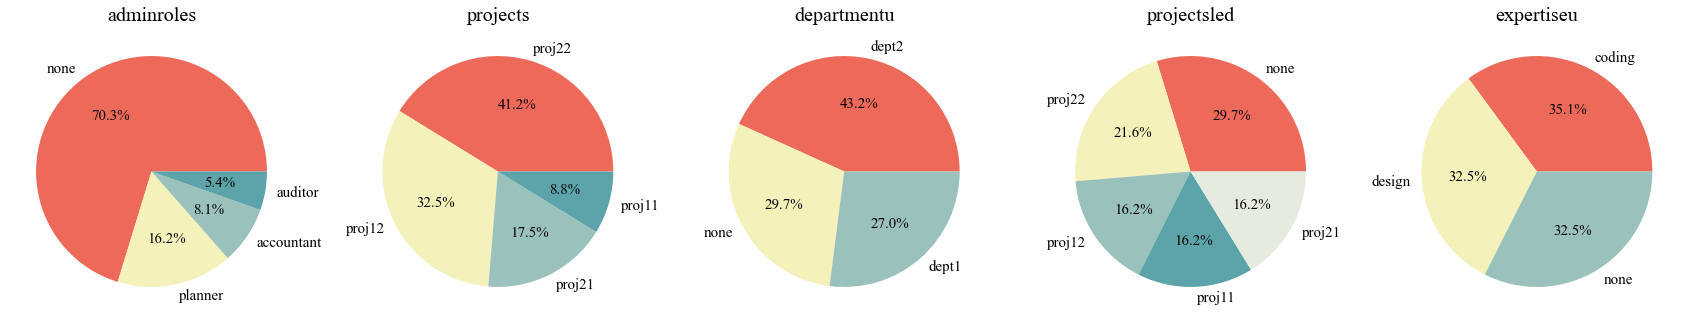

In [41]:
fontdict_title = {'fontsize': 20, 'fontname': 'Times New Roman'}
fontdict_labels = {'fontsize': 15, 'fontname': 'Times New Roman'}
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(30,50))
color_palette = ['#ED6A5A', '#F4F1BB', '#9BC1BC', '#5CA4A9', '#E6EBE0']
#'#EFC164', '#F3835D', '#F35955', '#286275', '#00434C']

# AX-1
ax1.set_title(acc_log_to_analyze.columns[0], fontdict=fontdict_title)
labels_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[0]].value_counts().index)
data_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[0]].value_counts())
ax1.pie(data_, labels=labels_, colors=color_palette[:len(labels_)], 
        autopct='%1.1f%%', textprops=fontdict_labels)

# AX-2
ax2.set_title(acc_log_to_analyze.columns[1], fontdict=fontdict_title)
labels_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[1]].value_counts().index)
data_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[1]].value_counts())
ax2.pie(data_, labels=labels_, colors=color_palette[:len(labels_)],
        autopct='%1.1f%%', textprops=fontdict_labels)

# AX-3
ax3.set_title(acc_log_to_analyze.columns[2], fontdict=fontdict_title)
labels_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[2]].value_counts().index)
data_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[2]].value_counts())
ax3.pie(data_, labels=labels_, colors=color_palette[:len(labels_)],
        autopct='%1.1f%%', textprops=fontdict_labels)

# AX-4
ax4.set_title(acc_log_to_analyze.columns[3], fontdict=fontdict_title)
labels_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[3]].value_counts().index)
data_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[3]].value_counts())
ax4.pie(data_, labels=labels_, colors=color_palette[:len(labels_)],
        autopct='%1.1f%%', textprops=fontdict_labels)

# AX-4
ax5.set_title(acc_log_to_analyze.columns[4], fontdict=fontdict_title)
labels_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[4]].value_counts().index)
data_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[4]].value_counts())
ax5.pie(data_, labels=labels_, colors=color_palette[:len(labels_)],
        autopct='%1.1f%%', textprops=fontdict_labels)

plt.show()

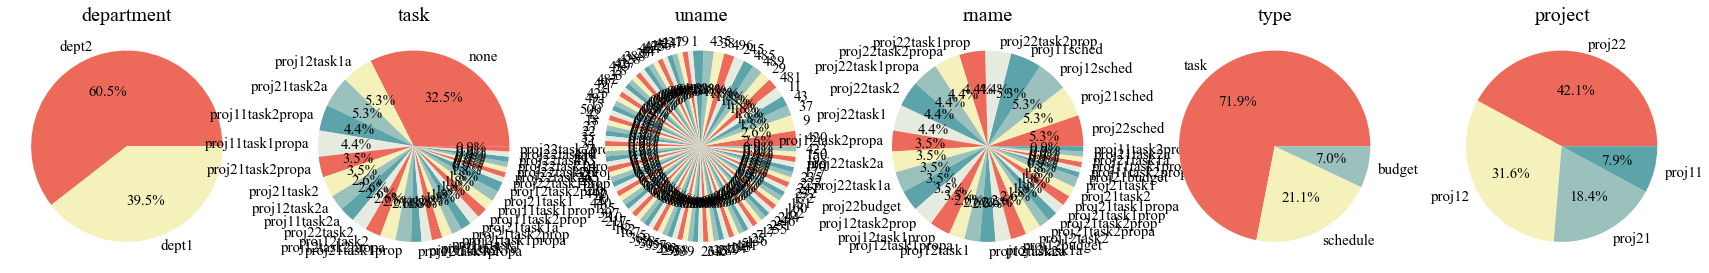

In [42]:
#fontdict_title = {'fontsize': 20, 'fontname': 'Times New Roman'}
#fontdict_labels = {'fontsize': 15, 'fontname': 'Times New Roman'}
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(30,50))
color_palette = ['#ED6A5A', '#F4F1BB', '#9BC1BC', '#5CA4A9', '#E6EBE0']
#'#EFC164', '#F3835D', '#F35955', '#286275', '#00434C']

# AX-1
ax1.set_title(acc_log_to_analyze.columns[11], fontdict=fontdict_title)
labels_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[11]].value_counts().index)
data_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[11]].value_counts())
ax1.pie(data_, labels=labels_, colors=color_palette[:len(labels_)], 
        autopct='%1.1f%%', textprops=fontdict_labels)

# AX-2
ax2.set_title(acc_log_to_analyze.columns[6], fontdict=fontdict_title)
labels_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[6]].value_counts().index)
data_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[6]].value_counts())
ax2.pie(data_, labels=labels_, colors=color_palette[:len(labels_)],
        autopct='%1.1f%%', textprops=fontdict_labels)

# AX-3
ax3.set_title(acc_log_to_analyze.columns[7], fontdict=fontdict_title)
labels_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[7]].value_counts().index)
data_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[7]].value_counts())
ax3.pie(data_, labels=labels_, colors=color_palette[:len(labels_)],
        autopct='%1.1f%%', textprops=fontdict_labels)

# AX-4
ax4.set_title(acc_log_to_analyze.columns[8], fontdict=fontdict_title)
labels_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[8]].value_counts().index)
data_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[8]].value_counts())
ax4.pie(data_, labels=labels_, colors=color_palette[:len(labels_)],
        autopct='%1.1f%%', textprops=fontdict_labels)

# AX-5
ax5.set_title(acc_log_to_analyze.columns[9], fontdict=fontdict_title)
labels_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[9]].value_counts().index)
data_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[9]].value_counts())
ax5.pie(data_, labels=labels_, colors=color_palette[:len(labels_)],
        autopct='%1.1f%%', textprops=fontdict_labels)

# AX-6
ax6.set_title(acc_log_to_analyze.columns[10], fontdict=fontdict_title)
labels_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[10]].value_counts().index)
data_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[10]].value_counts())
ax6.pie(data_, labels=labels_, colors=color_palette[:len(labels_)],
        autopct='%1.1f%%', textprops=fontdict_labels)

plt.show()

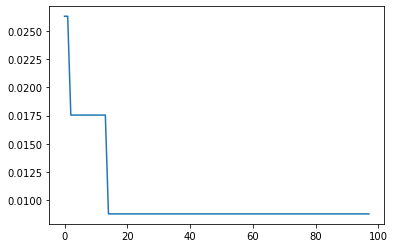

In [43]:
test = acc_log_to_analyze.uname.value_counts(normalize=True)
plt.plot(range(len(test)), test)

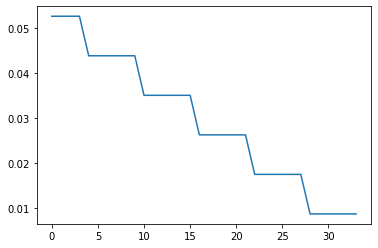

In [44]:
test = acc_log_to_analyze.rname.value_counts(normalize=True)
plt.plot(range(len(test)), test)

## IoT

In [6]:
### Load an access log
#file_path = "../data/HC-universal.csv"
file_path = "../../SecondYear/01-Datasets/IOT-AL-universal.csv"
acc_log = pd.read_csv(file_path)
acc_log = acc_log[acc_log.columns[1:]]

print("### *** Access Log loaded *** ###")
print(acc_log.info())

### *** Access Log loaded *** ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5702400 entries, 0 to 5702399
Data columns (total 14 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   role         object
 1   age          int64 
 2   health       object
 3   uname        int64 
 4   type         object
 5   area         object
 6   mode         object
 7   temperature  int64 
 8   lockstatus   object
 9   rname        int64 
 10  location     object
 11  timeday      object
 12  op           object
 13  ACTION       int64 
dtypes: int64(5), object(9)
memory usage: 609.1+ MB
None


In [7]:
### Get all resources
res = acc_log.rname.unique()
print("# resources:", len(res), "\t Head ->", res[:5], "\t tail -> ", res[-5:])

### Get all users
users = acc_log.uname.unique()
print("# users:", len(users), "\t Head ->", users[:5], "\t tail -> ", users[-5:])

# resources: 990 	 Head -> [0 1 2 3 4] 	 tail ->  [985 986 987 988 989]
# users: 120 	 Head -> [0 1 2 3 4] 	 tail ->  [118 119 120 121 122]


### Normal

#### Resources

Done!


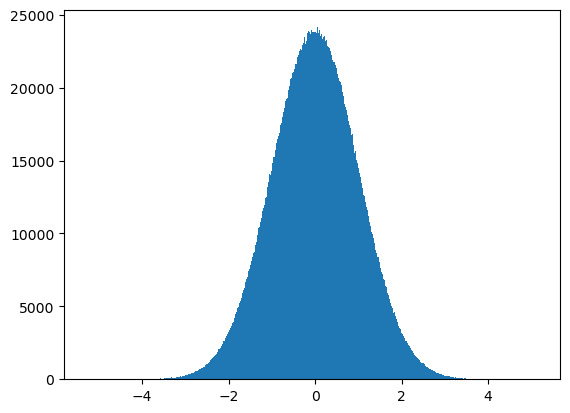

In [25]:
proba_param = {"mu": 0, "sigma": 1}
prob = get_probability_distribution(len(res), len(acc_log), proba_param, "normal")
df_res_prob = pd.DataFrame({"UID": res, "prob": prob})
print("Done!")

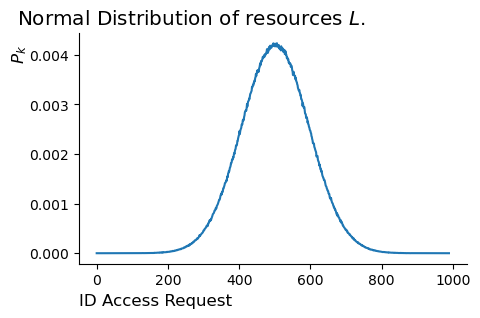

In [26]:
### Selection only user-resource access requests

#fpath = Path(mpl.get_data_path(), "C:\\Users\\danie\\AppData\\Local\\Microsoft\\Windows\\Fonts\\mulish-regular.ttf")


fig, ax = plt.subplots(figsize=(5, 3))
ax.spines[['right', 'top']].set_visible(False)
to_plot = df_res_prob.prob
ax.plot(range(len(to_plot)), to_plot)
ax.set_xlabel('ID Access Request', loc="left", size="large")
ax.set_ylabel('$P_k$', loc="top", size="large", parse_math=True)
ax.yaxis.set_label_coords(-0.13,0.95)
ax.set_title("Normal Distribution of resources $L$.", size="x-large", x=0.29, y=1, parse_math=True)
plt.show()

In [27]:
### Get sample distribution
normal_acc_log = get_sample_by_distribution(acc_log, len(acc_log), df_res_prob, "rname")
print("*** Done! ***")

*** Done! ***


Done!


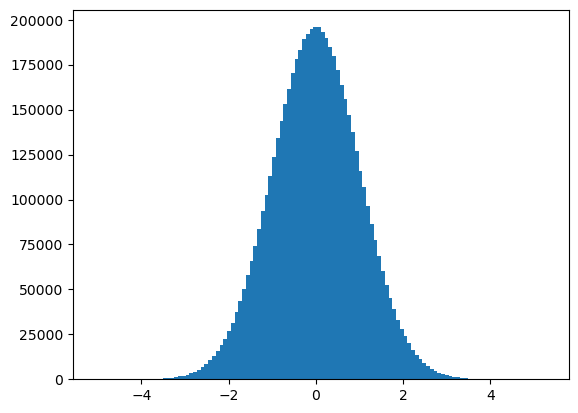

In [31]:
proba_param = {"mu": 0, "sigma": 1}
prob = get_probability_distribution(len(users), len(normal_acc_log), proba_param, "normal")
df_user_prob = pd.DataFrame({"UID": users, "prob": prob})
print("Done!")

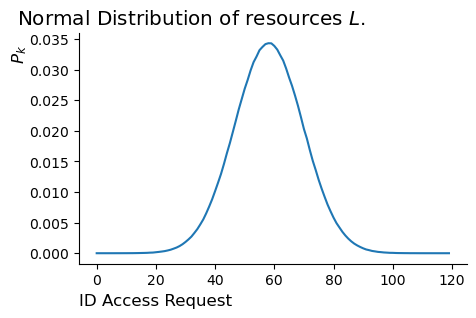

In [32]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.spines[['right', 'top']].set_visible(False)
to_plot = df_user_prob.prob
ax.plot(range(len(to_plot)), to_plot)
ax.set_xlabel('ID Access Request', loc="left", size="large")
ax.set_ylabel('$P_k$', loc="top", size="large", parse_math=True)
ax.yaxis.set_label_coords(-0.13,0.95)
ax.set_title("Normal Distribution of resources $L$.", size="x-large", x=0.29, y=1, parse_math=True)
plt.show()

In [33]:
### Get sample distribution
normal_acc_log = get_sample_by_distribution(normal_acc_log, len(normal_acc_log), df_user_prob, "uname")
print("*** Done! ***")

*** Done! ***


In [34]:
normal_acc_log.to_csv("IoT-normal-universal.csv")

### Exponencial

Done!


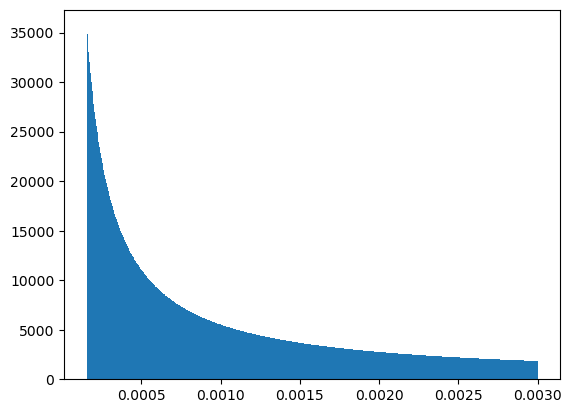

In [51]:
proba_param = {"lam": 0.003}
prob = get_probability_distribution(len(res), len(acc_log), proba_param, "exponential")
df_res_prob = pd.DataFrame({"UID": res, "prob": prob})
print("Done!")

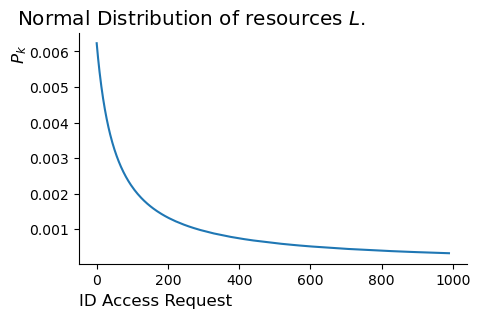

In [52]:
### Se comprueba la distribución
fig, ax = plt.subplots(figsize=(5, 3))
ax.spines[['right', 'top']].set_visible(False)
to_plot = df_res_prob.prob
ax.plot(range(len(to_plot)), to_plot)
ax.set_xlabel('ID Access Request', loc="left", size="large")
ax.set_ylabel('$P_k$', loc="top", size="large", parse_math=True)
ax.yaxis.set_label_coords(-0.13,0.95)
ax.set_title("Normal Distribution of resources $L$.", size="x-large", x=0.29, y=1, parse_math=True)
plt.show()

In [53]:
### Get sample distribution
expo_acc_log = get_sample_by_distribution(acc_log, len(acc_log), df_res_prob, "rname")
print("*** Done! ***")

*** Done! ***


Done!


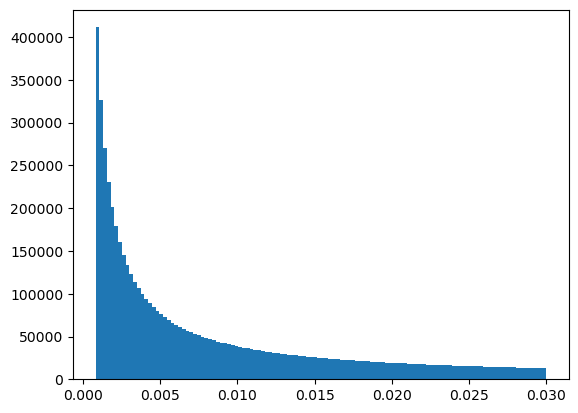

In [59]:
proba_param = {"lam": 0.03}
prob = get_probability_distribution(len(users), len(expo_acc_log), proba_param, "exponential")
df_user_prob = pd.DataFrame({"UID": users, "prob": prob})
print("Done!")

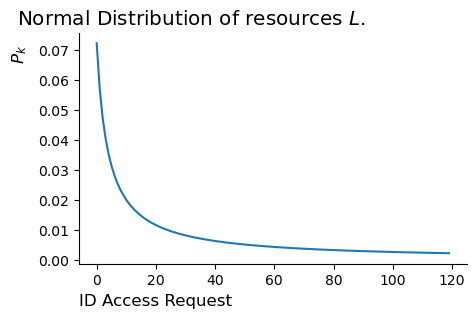

In [60]:
### Se comprueba la distribución
fig, ax = plt.subplots(figsize=(5, 3))
ax.spines[['right', 'top']].set_visible(False)
to_plot = df_user_prob.prob
ax.plot(range(len(to_plot)), to_plot)
ax.set_xlabel('ID Access Request', loc="left", size="large")
ax.set_ylabel('$P_k$', loc="top", size="large", parse_math=True)
ax.yaxis.set_label_coords(-0.13,0.95)
ax.set_title("Normal Distribution of resources $L$.", size="x-large", x=0.29, y=1, parse_math=True)
plt.show()

In [61]:
### Get sample distribution
expo_acc_log = get_sample_by_distribution(expo_acc_log, len(expo_acc_log), df_user_prob, "uname")
print("*** Done! ***")

*** Done! ***


In [62]:
expo_acc_log.to_csv("IoT-expo-universal.csv")

In [64]:
del expo_acc_log, to_plot

### Poisson

Done!


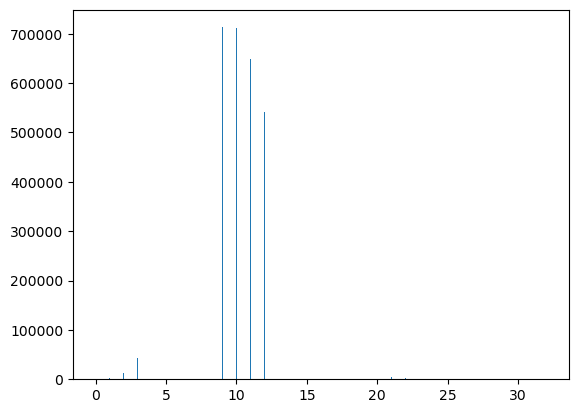

In [69]:
proba_param = {"lam": 10}
prob = get_probability_distribution(len(res), len(acc_log), proba_param, "poisson")
df_res_prob = pd.DataFrame({"UID": res, "prob": prob})
print("Done!")

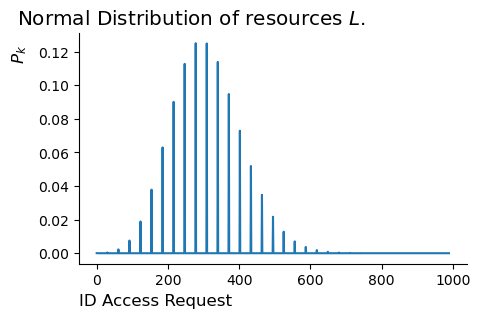

In [70]:
### Se comprueba la distribución
fig, ax = plt.subplots(figsize=(5, 3))
ax.spines[['right', 'top']].set_visible(False)
to_plot = df_res_prob.prob
ax.plot(range(len(to_plot)), to_plot)
ax.set_xlabel('ID Access Request', loc="left", size="large")
ax.set_ylabel('$P_k$', loc="top", size="large", parse_math=True)
ax.yaxis.set_label_coords(-0.13,0.95)
ax.set_title("Normal Distribution of resources $L$.", size="x-large", x=0.29, y=1, parse_math=True)
plt.show()

In [71]:
### Get sample distribution
poisson_acc_log = get_sample_by_distribution(acc_log, len(acc_log), df_res_prob, "rname")
print("*** Done! ***")

*** Done! ***


Done!


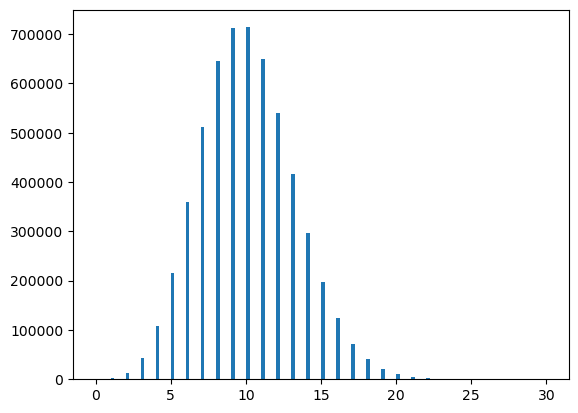

In [75]:
proba_param = {"lam": 10}
prob = get_probability_distribution(len(users), len(poisson_acc_log), proba_param, "poisson")
df_user_prob = pd.DataFrame({"UID": users, "prob": prob})
print("Done!")

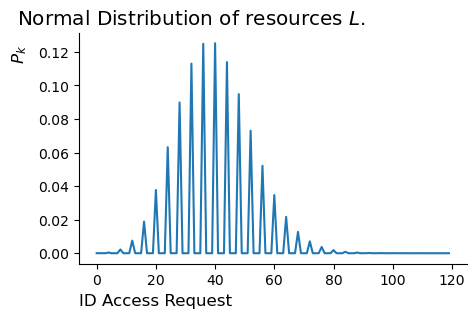

In [76]:
### Se comprueba la distribución
fig, ax = plt.subplots(figsize=(5, 3))
ax.spines[['right', 'top']].set_visible(False)
to_plot = df_user_prob.prob
ax.plot(range(len(to_plot)), to_plot)
ax.set_xlabel('ID Access Request', loc="left", size="large")
ax.set_ylabel('$P_k$', loc="top", size="large", parse_math=True)
ax.yaxis.set_label_coords(-0.13,0.95)
ax.set_title("Normal Distribution of resources $L$.", size="x-large", x=0.29, y=1, parse_math=True)
plt.show()

In [77]:
### Get sample distribution
poisson_acc_log = get_sample_by_distribution(poisson_acc_log, len(poisson_acc_log), df_user_prob, "uname")
print("*** Done! ***")

*** Done! ***


In [78]:
poisson_acc_log.to_csv("IoT-poisson-universal.csv")

In [ ]:
del poisson_acc_log, to_plot

### AMZ Distri

In [15]:
with open("resrs-distri", "rb") as fp:   # Unpickling
    b = pickle.load(fp)
print("Done len:", len(b))

Done len: 990


In [16]:
df_res_prob = pd.DataFrame({"RID": res, "prob": b})
df_res_prob.head()

,RID,prob
0,0,0.000232
1,1,0.000232
2,2,0.000232
3,3,0.000232
4,4,0.000232


In [17]:
### Get sample distribution
amz_acc_log = get_sample_by_distribution(acc_log, len(acc_log), df_res_prob, "rname")
print("*** Done! ***")
print(amz_acc_log.info())

*** Done! ***
<class 'pandas.core.frame.DataFrame'>
Index: 5701990 entries, 2974689 to 3173511
Data columns (total 14 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   role         object
 1   age          int64 
 2   health       object
 3   uname        int64 
 4   type         object
 5   area         object
 6   mode         object
 7   temperature  int64 
 8   lockstatus   object
 9   rname        int64 
 10  location     object
 11  timeday      object
 12  op           object
 13  ACTION       int64 
dtypes: int64(5), object(9)
memory usage: 652.5+ MB
None


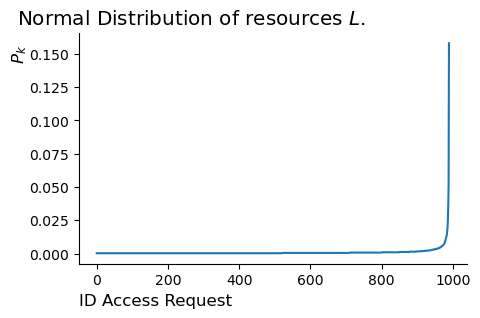

In [18]:
### Se comprueba la distribución
fig, ax = plt.subplots(figsize=(5, 3))
ax.spines[['right', 'top']].set_visible(False)
to_plot = df_res_prob.prob
ax.plot(range(len(to_plot)), to_plot)
ax.set_xlabel('ID Access Request', loc="left", size="large")
ax.set_ylabel('$P_k$', loc="top", size="large", parse_math=True)
ax.yaxis.set_label_coords(-0.13,0.95)
ax.set_title("Normal Distribution of resources $L$.", size="x-large", x=0.29, y=1, parse_math=True)
plt.show()

In [19]:
with open("users-distri", "rb") as fp:   # Unpickling
    b = pickle.load(fp)
print("Done len:", len(b))
df_user_prob = pd.DataFrame({"UID": users, "prob": b})
df_user_prob.head()

Done len: 120


,UID,prob
0,0,0.002674
1,1,0.002674
2,2,0.002674
3,3,0.002674
4,4,0.002674


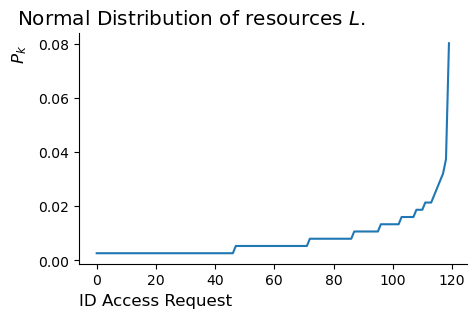

In [20]:
### Se comprueba la distribución
fig, ax = plt.subplots(figsize=(5, 3))
ax.spines[['right', 'top']].set_visible(False)
to_plot = df_user_prob.prob
ax.plot(range(len(to_plot)), to_plot)
ax.set_xlabel('ID Access Request', loc="left", size="large")
ax.set_ylabel('$P_k$', loc="top", size="large", parse_math=True)
ax.yaxis.set_label_coords(-0.13,0.95)
ax.set_title("Normal Distribution of resources $L$.", size="x-large", x=0.29, y=1, parse_math=True)
plt.show()

In [21]:
### Get sample distribution
amz_acc_log = get_sample_by_distribution(amz_acc_log, len(amz_acc_log), df_user_prob, "uname")
print("*** Done! ***")
print(amz_acc_log.info())

*** Done! ***
<class 'pandas.core.frame.DataFrame'>
Index: 5701883 entries, 35382 to 5512204
Data columns (total 14 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   role         object
 1   age          int64 
 2   health       object
 3   uname        int64 
 4   type         object
 5   area         object
 6   mode         object
 7   temperature  int64 
 8   lockstatus   object
 9   rname        int64 
 10  location     object
 11  timeday      object
 12  op           object
 13  ACTION       int64 
dtypes: int64(5), object(9)
memory usage: 652.5+ MB
None


In [22]:
amz_acc_log.to_csv("IoT-amz-universal.csv")

In [23]:
del amz_acc_log, to_plot

## HC

In [7]:
### Get all resources
res = acc_log.rname.unique()
print("# resources:", len(res), "\t Head ->", res[:5], "\t tail -> ", res[-5:])

### Get all users
users = acc_log.uname.unique()
print("# users:", len(users), "\t Head ->", users[:5], "\t tail -> ", users[-5:])

# resources: 4960 	 Head -> [0 1 2 3 4] 	 tail ->  [2467 2468 2469 2470 2471]
# users: 31 	 Head -> ['oncNurse1' 'carNurse1' 'doc1' 'doc2' 'doc3'] 	 tail ->  ['doc25' 'oncPat1' 'carPat1' 'oncAgent1' 'carAgent1']


### Uniforme

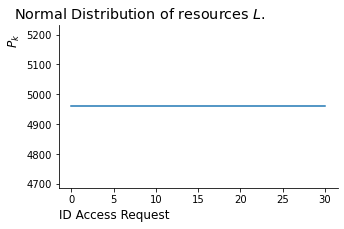

In [5]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.spines[['right', 'top']].set_visible(False)
to_plot = acc_log.uname.value_counts()
ax.plot(range(len(to_plot)), to_plot)
ax.set_xlabel('ID Access Request', loc="left", size="large")
ax.set_ylabel('$P_k$', loc="top", size="large", parse_math=True)
ax.yaxis.set_label_coords(-0.13,0.95)
ax.set_title("Normal Distribution of resources $L$.", size="x-large", x=0.29, y=1, parse_math=True)
plt.show()

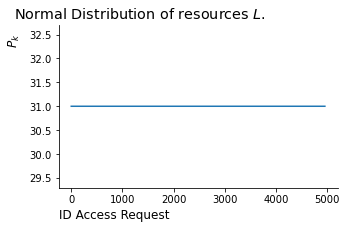

In [6]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.spines[['right', 'top']].set_visible(False)
to_plot = acc_log.rname.value_counts()
ax.plot(range(len(to_plot)), to_plot)
ax.set_xlabel('ID Access Request', loc="left", size="large")
ax.set_ylabel('$P_k$', loc="top", size="large", parse_math=True)
ax.yaxis.set_label_coords(-0.13,0.95)
ax.set_title("Normal Distribution of resources $L$.", size="x-large", x=0.29, y=1, parse_math=True)
plt.show()

### Exponencial

Done!


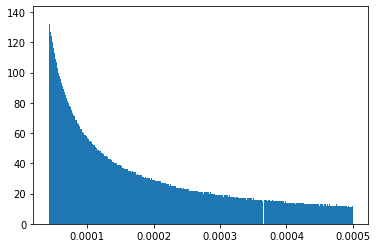

In [14]:
proba_param = {"lam": 0.0005}
prob = get_probability_distribution(len(res), len(acc_log), proba_param, "exponential")
df_res_prob = pd.DataFrame({"UID": res, "prob": prob})
print("Done!")

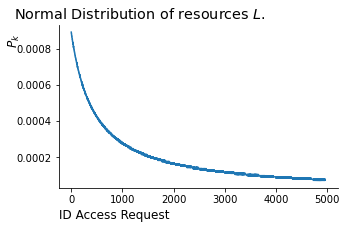

In [15]:
### Se comprueba la distribución
fig, ax = plt.subplots(figsize=(5, 3))
ax.spines[['right', 'top']].set_visible(False)
to_plot = df_res_prob.prob
ax.plot(range(len(to_plot)), to_plot)
ax.set_xlabel('ID Access Request', loc="left", size="large")
ax.set_ylabel('$P_k$', loc="top", size="large", parse_math=True)
ax.yaxis.set_label_coords(-0.13,0.95)
ax.set_title("Normal Distribution of resources $L$.", size="x-large", x=0.29, y=1, parse_math=True)
plt.show()

In [16]:
### Get sample distribution
expo_acc_log = get_sample_by_distribution(acc_log, len(acc_log), df_res_prob, "rname")
print("*** Done! ***")

*** Done! ***


Done!


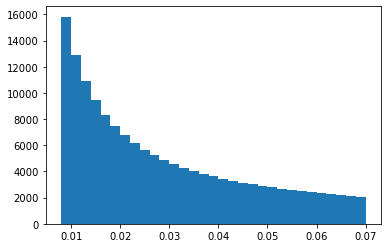

In [19]:
proba_param = {"lam": 0.07}
prob = get_probability_distribution(len(users), len(expo_acc_log), proba_param, "exponential")
df_user_prob = pd.DataFrame({"UID": users, "prob": prob})
print("Done!")

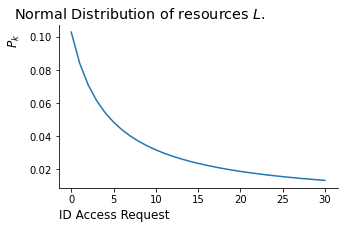

In [20]:
### Se comprueba la distribución
fig, ax = plt.subplots(figsize=(5, 3))
ax.spines[['right', 'top']].set_visible(False)
to_plot = df_user_prob.prob
ax.plot(range(len(to_plot)), to_plot)
ax.set_xlabel('ID Access Request', loc="left", size="large")
ax.set_ylabel('$P_k$', loc="top", size="large", parse_math=True)
ax.yaxis.set_label_coords(-0.13,0.95)
ax.set_title("Normal Distribution of resources $L$.", size="x-large", x=0.29, y=1, parse_math=True)
plt.show()

In [21]:
### Get sample distribution
expo_acc_log = get_sample_by_distribution(expo_acc_log, len(expo_acc_log), df_user_prob, "uname")
print("*** Done! ***")

*** Done! ***


In [22]:
expo_acc_log.to_csv("HC-expo-universal.csv")

In [23]:
del expo_acc_log, to_plot

### Poisson

Done!


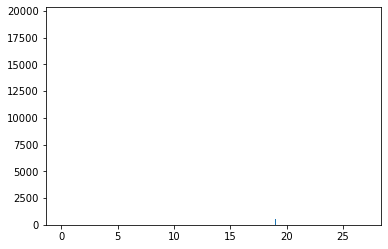

In [24]:
proba_param = {"lam": 10}
prob = get_probability_distribution(len(res), len(acc_log), proba_param, "poisson")
df_res_prob = pd.DataFrame({"UID": res, "prob": prob})
print("Done!")

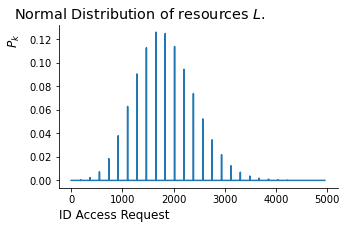

In [25]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.spines[['right', 'top']].set_visible(False)
to_plot = df_res_prob.prob
ax.plot(range(len(to_plot)), to_plot)
ax.set_xlabel('ID Access Request', loc="left", size="large")
ax.set_ylabel('$P_k$', loc="top", size="large", parse_math=True)
ax.yaxis.set_label_coords(-0.13,0.95)
ax.set_title("Normal Distribution of resources $L$.", size="x-large", x=0.29, y=1, parse_math=True)
plt.show()

In [26]:
### Get sample distribution
poisson_acc_log = get_sample_by_distribution(acc_log, len(acc_log), df_res_prob, "rname")
print("*** Done! ***")

*** Done! ***


Done!


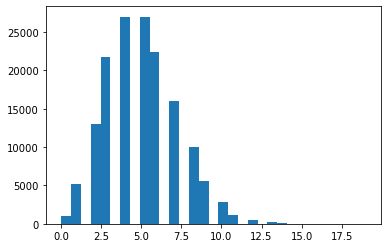

In [28]:
proba_param = {"lam": 5}
prob = get_probability_distribution(len(users), len(poisson_acc_log), proba_param, "poisson")
df_user_prob = pd.DataFrame({"UID": users, "prob": prob})
print("Done!")

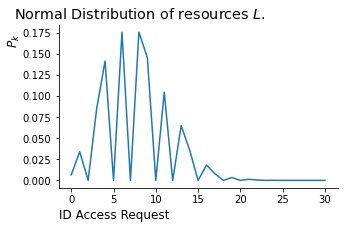

In [29]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.spines[['right', 'top']].set_visible(False)
to_plot = df_user_prob.prob
ax.plot(range(len(to_plot)), to_plot)
ax.set_xlabel('ID Access Request', loc="left", size="large")
ax.set_ylabel('$P_k$', loc="top", size="large", parse_math=True)
ax.yaxis.set_label_coords(-0.13,0.95)
ax.set_title("Normal Distribution of resources $L$.", size="x-large", x=0.29, y=1, parse_math=True)
plt.show()

In [30]:
### Get sample distribution
poisson_acc_log = get_sample_by_distribution(poisson_acc_log, len(poisson_acc_log), df_user_prob, "uname")
print("*** Done! ***")

*** Done! ***


In [31]:
poisson_acc_log.to_csv("HC-poisson-universal.csv")

In [32]:
del poisson_acc_log, acc_log, to_plot

## UN

In [6]:
### Load an access log
file_path = "../data/UN-universal.csv"
#file_path = "../../SecondYear/01-Datasets/UN-universal.csv"
acc_log = pd.read_csv(file_path)
acc_log = acc_log[acc_log.columns[1:]]

print("### *** Access Log loaded *** ###")
print(acc_log.info())

FileNotFoundError: [Errno 2] No such file or directory: '../data/UN-universal.csv'

In [ ]:
### Get all resources
res = acc_log.rname.unique()
print("# resources:", len(res), "\t Head ->", res[:5], "\t tail -> ", res[-5:])

### Get all users
users = acc_log.uname.unique()
print("# users:", len(users), "\t Head ->", users[:5], "\t tail -> ", users[-5:])